In [25]:
import os
os.chdir('D://scratch_backup//perl//jdftx_mod_test//denser_mesh//sicko_mode')
import numpy as np
import funcs as func
import matplotlib.pyplot as plt
bandfile='water.bandProjections'
gvecfile='water.Gvectors'
eigfile='water.eigenvals'
proj, nStates, nBands, nProj, nSpecies, nOrbsPerAtom = func.parse_bandfile(bandfile)
wk, iGarr, k_points, nStates = func.parse_gvecfile(gvecfile)
E = func.parse_eigfile(eigfile, nStates)
header, data = func.parse_dos('water.dos')
projec_labels = [
	'H1 1s', 'H2 1s', 'O 2s', 'O 2px', 'O 2py', 'O 2pz'
]
def T_ijk(iorb, jband, kstate):
	return proj[kstate][jband][iorb]
def P_uvjk(uorb,vorb,jband, kstate):
	return np.conjugate(T_ijk(uorb, jband, kstate))*T_ijk(vorb, jband, kstate)
def e_jk(jband,kstate):
	return E[kstate][jband]
def H_uvk(uorb,vorb,kstate):
	sum_hold = 0
	for j in range(nBands):
		sum_hold += e_jk(j, kstate)*P_uvjk(uorb, vorb, j, kstate)
	return sum_hold
def pCOHP_uvk(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, vorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid
def pCOHP_uv(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid

In [26]:
def Hk_atomic_matrix(orb_idcs, k, array=False):
	dim = len(orb_idcs)
	out = []
	for i in range(dim):
		out.append([])
		for j in range(dim):
			out[-1].append(0)
	for i in range(dim):
		for j in range(dim):
			out[i][j] = H_uvk(orb_idcs[i],orb_idcs[j],k)
	if array:
		return np.array(out)
	else:
		return out

def H_atomic_matrices(orb_idcs, k_points, array=False, select=None):
	if select is None:
		select = range(len(k_points))
	out = []
	for k in select:
		out.append(Hk_atomic_matrix(orb_idcs, k, array=array))
	return out

def H_atomic_matrix(orb_idcs, select=None):
	matrices = H_atomic_matrices(orb_idcs, k_points, array=True, select=select)
	out = np.zeros(np.shape(matrices[0]), dtype=complex)
	for i in range(len(k_points)):
		out += matrices[i]*wk[i]
	return out
orbs = [0,1,2,3,4,5]
H_gamma_atomic = Hk_atomic_matrix(orbs, 0, array=True)
Hks_atomic = H_atomic_matrices(orbs, k_points, array=True)
H_atomic = H_atomic_matrix(orbs)

In [27]:
def smear(x, smear_fac, height, mean):
	return height*(np.exp(-((x - mean)**2/(smear_fac))))

In [28]:
atomic_eigs = np.linalg.eig(H_atomic)
norbs = len(orbs)
nvals = len(atomic_eigs[0]) # this will be the same number, but calling them separate for indexing clarity
heights = []
for i in range(norbs):
	heights.append([])
	for j in range(nvals):
		coef = atomic_eigs[1][j][i]
		heights[-1].append(np.abs(coef)**2)
smear_fac = 0.0001
dE = smear_fac/10
E_grid = np.arange(min(np.real(atomic_eigs[0])) - 300*smear_fac, max(np.real(atomic_eigs[0])) + 300*smear_fac, dE)
pdppCOHPs = []
for i in range(norbs):
	pdppCOHP = np.zeros(np.shape(E_grid))
	for j, mean in enumerate(np.real(atomic_eigs[0])):
		transformer = lambda x: smear(x, smear_fac, np.real(heights[i][j]), mean)
		pdppCOHP += transformer(E_grid)
	pdppCOHPs.append(pdppCOHP)

In [42]:
diagonal_ocs = []
diag_height = 1
E_grid_diag = np.arange(np.min(np.real(H_atomic)) - 300*smear_fac, np.max(np.real(H_atomic)) + 300*smear_fac, dE)
for i in range(norbs):
	transformer = lambda x: smear(x, smear_fac, diag_height, np.real(H_atomic[i][i]))
	diagonal_ocs.append(transformer(E_grid_diag))

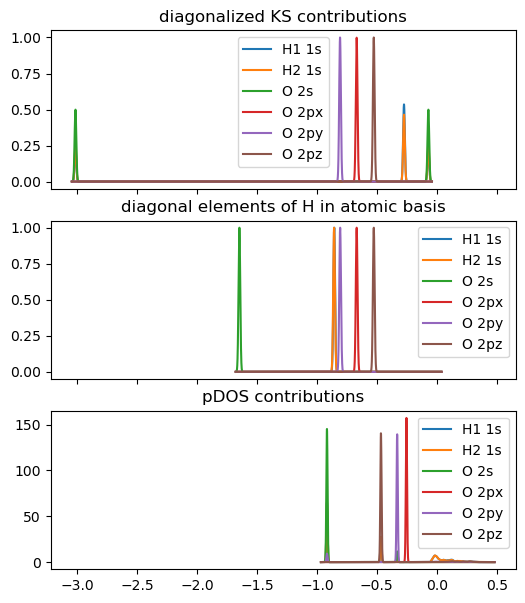

In [46]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6,7))
for orb in orbs:
	axes[0].plot(E_grid, pdppCOHPs[orb], label=projec_labels[orb])
	axes[1].plot(E_grid_diag, diagonal_ocs[orb], label=projec_labels[orb])
axes[0].legend()
axes[0].set_title('diagonalized KS contributions')
axes[1].legend()
axes[1].set_title('diagonal elements of H in atomic basis')
# pDOS ordering
# O 2s, O 2px, O 2py, O 2pz, H1 1s, H2 2s
#  1      2      3      4      5      6
#  0      1      2      3      4      5
# H1 1s, H2 1s, O 2s, O 2px, O 2py, O 2pz
reorder = [5, 6, 1, 2, 3, 4]
for i, idx in enumerate(reorder):
	axes[2].plot(data[0], data[idx], label=projec_labels[i])
axes[2].legend()
axes[2].set_title('pDOS contributions')
plt.savefig('diagonal2_orbtal_contrbs.png')

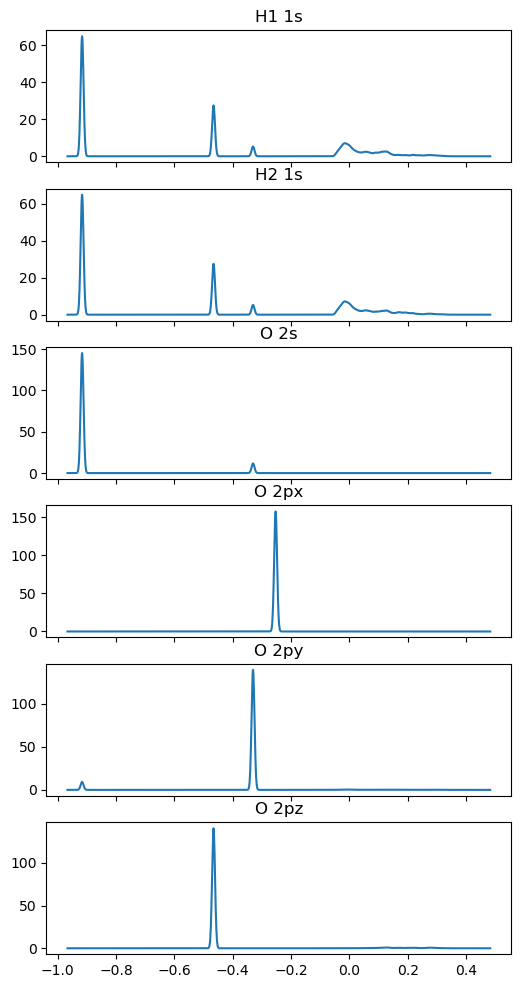

In [52]:
fig, axes = plt.subplots(len(orbs), 1, sharex=True, figsize=(6,2*len(orbs)))

reorder = [5, 6, 1, 2, 3, 4]
for i, idx in enumerate(reorder):
	axes[i].plot(data[0], data[idx])
	axes[i].set_title(projec_labels[i])
# for orb in orbs:
# 	axes[orb].plot(data[0], data[1 + orb])
# 	axes[orb].set_title(header[1 + orb])
plt.savefig('pdos_stretched_out.png')